## Preprocessing_Training (IS2) - DayByDay Modeling

This notebook creates benchmark linear models for by puzzle day modeling. As there were concerns about data scarcity, a 90/10 train/test split was used here (80/20 for full all 15x15 puzzles model). 

See 04c_IS2_Modeling-ByPuzzleDay for full model by puzzle day modeling results.

## Preprocessing and Training

In [1]:
import pandas as pd
import numpy as np
import os
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import __version__ as sklearn_version
from sklearn.preprocessing import scale
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV, learning_curve
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectKBest, f_regression
import datetime
from library.sb_utils import save_file

### Load Data

In [2]:
df = pd.read_csv('../data/df_for_modeling_no_decay_weighting.csv')
df.head()

,P_Date,P_Date_str,IS2_Completed,Comp_Date,Comp_Date_str,Comp_Hr,Solve_day_phase,IS_per_sdp_avg_past_diff_from_RPB,DOW,DOW_num,...,Circle_Count,Shade_Count,Unusual_Sym,Black_Square_Fill,Outside_Grid,Unchecked_Sq,Uniclue,Duplicate_Answers,Quantum,Wordplay
0,2022-05-31 00:00:00,2022-05-31,1.0,2024-02-25 14:42:15,2024-02-25,14,3.0,-16.53,Tuesday,3.0,...,0,0,0,0,0,0,0,0,0,4.0
1,2022-05-30 00:00:00,2022-05-30,1.0,2024-02-25 14:32:11,2024-02-25,14,3.0,-16.49,Monday,2.0,...,0,0,0,0,0,0,0,0,0,3.0
2,2022-05-29 00:00:00,2022-05-29,1.0,2024-02-25 13:40:36,2024-02-25,13,3.0,-16.57,Sunday,1.0,...,0,0,1,0,0,1,0,0,0,5.0
3,2024-02-25 00:00:00,2024-02-25,1.0,2024-02-25 10:03:32,2024-02-25,10,2.0,-13.76,Sunday,1.0,...,0,0,0,0,0,0,0,0,0,12.0
4,2021-11-25 00:00:00,2021-11-25,1.0,2024-02-24 23:11:23,2024-02-24,23,4.0,-11.35,Thursday,5.0,...,0,0,0,0,0,0,0,0,0,1.0


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1108 entries, 0 to 1107
Data columns (total 50 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   P_Date                                1108 non-null   object 
 1   P_Date_str                            1108 non-null   object 
 2   IS2_Completed                         1108 non-null   float64
 3   Comp_Date                             1108 non-null   object 
 4   Comp_Date_str                         1108 non-null   object 
 5   Comp_Hr                               1108 non-null   int64  
 6   Solve_day_phase                       1108 non-null   float64
 7   IS_per_sdp_avg_past_diff_from_RPB     1108 non-null   float64
 8   DOW                                   1108 non-null   object 
 9   DOW_num                               1108 non-null   float64
 10  GMST(m)                               1108 non-null   float64
 11  IS2_ST(m)        

### Filter Data

In [4]:
df['DOW_num'].unique()

array([3., 2., 1., 5., 7., 6., 4.])

In [132]:
df_filter = df.copy()

In [133]:
# Filter to a specific puzzle day
#df_filter = (df_filter.loc[(df_filter['DOW_num'] == 1)]) # Sun
#df_filter = (df_filter.loc[(df_filter['DOW_num'] == 2)]) # Mon
#df_filter = (df_filter.loc[(df_filter['DOW_num'] == 3)]) # Tue
#df_filter = (df_filter.loc[(df_filter['DOW_num'] == 4)]) # Wed
#df_filter = (df_filter.loc[(df_filter['DOW_num'] == 5)]) # Thu
#df_filter = (df_filter.loc[(df_filter['DOW_num'] == 6)]) # Fri
df_filter = (df_filter.loc[(df_filter['DOW_num'] == 7)]) # Sat

In [134]:
#Will give d/0 errors if leave in, since we've filtered down to only 1 day
df_filter.drop(['DOW_num'],inplace=True,axis=1)

In [135]:
# Strip down to only the features we need to benchmark and the target feature
df_filter = df_filter[['overall_day_mean_IST(m)', 'IS2_ST(m)']]

In [136]:
# df_filter.drop(['DOW_num'],inplace=True,axis=1)

In [137]:
df_filter.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 158 entries, 7 to 1096
Data columns (total 2 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   overall_day_mean_IST(m)  158 non-null    float64
 1   IS2_ST(m)                158 non-null    float64
dtypes: float64(2)
memory usage: 3.7 KB


In [138]:
df_model1 = df_filter[['overall_day_mean_IST(m)','IS2_ST(m)']]

In [139]:
df_model1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 158 entries, 7 to 1096
Data columns (total 2 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   overall_day_mean_IST(m)  158 non-null    float64
 1   IS2_ST(m)                158 non-null    float64
dtypes: float64(2)
memory usage: 3.7 KB


### Train Test Split
90/10 for by day models (80/20 for all 15x15 puzzles models)

In [140]:
len(df_model1) * .90, len(df_model1) * .10

(142.20000000000002, 15.8)

In [141]:
X_train, X_test, y_train, y_test = train_test_split(df_model1.drop(columns='IS2_ST(m)'), 
                                                    df_model1['IS2_ST(m)'], test_size=0.10, 
                                                    random_state=47)

In [142]:
y_train.shape, y_test.shape

((142,), (16,))

In [143]:
y_train

122    22.983333
503    26.600000
473    15.650000
307    23.583333
696    45.183333
         ...    
497    39.850000
57     17.383333
490    80.983333
923    33.850000
930    22.633333
Name: IS2_ST(m), Length: 142, dtype: float64

In [144]:
X_train.shape, X_test.shape

((142, 1), (16, 1))

### Pre-Modeling: IS2 Mean Solve Time Across All 15x15 Puzzles as Per Solve (IS1_ST) Predictor (aka "Dummy Model")

In [145]:
#Target feature (IS1_ST(m)) training set mean
train_mean = y_train.mean()
train_mean

34.256220657277005

In [146]:
#Fitting dummy regressor to training data (from sklearn). Outputs the training set mean.
dumb_reg = DummyRegressor(strategy='mean')
dumb_reg.fit(X_train, y_train)
dumb_reg.constant_

array([[34.25622066]])

In [147]:
y_tr_pred = dumb_reg.predict(X_train)
y_tr_pred[:5]

array([34.25622066, 34.25622066, 34.25622066, 34.25622066, 34.25622066])

In [148]:
y_te_pred = train_mean * np.ones(len(y_test))

#### R-Squared (COD)

In [149]:
#Compute R-squared for target mean on training set (will be zero, since we are calculating mean on training set), and on test set (should be slightly different from zero)
r2_score(y_train, y_tr_pred), r2_score(y_test, y_te_pred)

(0.0, -0.05769021619190107)

proportion of the variance for a dependent variable that's explained by our features. It's close to zero for the dummy model as expected.

#### Mean Absolute Error (MAE)

In [150]:
MAEs_dummy = mean_absolute_error(y_train, y_tr_pred), mean_absolute_error(y_test, y_te_pred)
MAEs_dummy

(13.893040402036632, 14.236971830985919)

#### Mean Squared Error (MSE)

In [151]:
#Calculate the Mean Squared Error (average of the square of the errors)
MSEs_dummy = mean_squared_error(y_train, y_tr_pred), mean_squared_error(y_test, y_te_pred)
MSEs_dummy

(344.51415731281276, 262.4211278006459)

#### Root Mean Squared Error (RMSE)

In [152]:
RMSEs_dummy = np.sqrt(mean_squared_error(y_train, y_tr_pred)), np.sqrt(mean_squared_error(y_test, y_te_pred))
RMSEs_dummy

(18.561092567863906, 16.19941751423939)

### Benchmark Linear Model 1: Puzzle Day-Specific, Whole-Sample Mean Global Median Solver (IS1) Solve Time as Sole Predictor of Individual Solve Times (IS1_STs)

In [30]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 123 entries, 386 to 956
Data columns (total 1 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   overall_day_mean_IST(m)  123 non-null    float64
dtypes: float64(1)
memory usage: 1.9 KB


In [28]:
#Filter existing train-test split down to just the ranking columns (train)
#X_train_ranking = X_train[["p_rank", "p_rank_pts", "p_log_rank", "p_opp_rank_diff", "p_opp_rank_pts_diff", "p_opp_log_rank_diff"]]

In [29]:
#Filter existing train-test split down to just the ranking columns (test)
#X_test_ranking = X_test[["p_rank", "p_rank_pts", "p_log_rank", "p_opp_rank_diff", "p_opp_rank_pts_diff", "p_opp_log_rank_diff"]]

In [31]:
lr_pipe = make_pipeline(
    SimpleImputer(strategy='median'), 
    StandardScaler(),
    SelectKBest(f_regression),
    LinearRegression()
)

In [32]:
#Dict of available parameters for linear regression pipe
lr_pipe.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'simpleimputer', 'standardscaler', 'selectkbest', 'linearregression', 'simpleimputer__add_indicator', 'simpleimputer__copy', 'simpleimputer__fill_value', 'simpleimputer__missing_values', 'simpleimputer__strategy', 'simpleimputer__verbose', 'standardscaler__copy', 'standardscaler__with_mean', 'standardscaler__with_std', 'selectkbest__k', 'selectkbest__score_func', 'linearregression__copy_X', 'linearregression__fit_intercept', 'linearregression__n_jobs', 'linearregression__normalize', 'linearregression__positive'])

In [33]:
#Define search grid parameters
k = [k+1 for k in range(len(X_train.columns))]

grid_params = {
    'standardscaler': [StandardScaler(), None],
    'simpleimputer__strategy': ['mean', 'median'],
    'selectkbest__k': k
}

In [34]:
#Call `GridSearchCV` with linear regression pipeline, passing in the above `grid_params`
#dict for parameters to evaluate with 5-fold cross-validation
lr_grid_cv = GridSearchCV(lr_pipe, param_grid=grid_params, cv=5)

In [35]:
#Conduct grid search for this ranking-restricted model. 
lr_grid_cv.fit(X_train, y_train)

C:\Users\jraks\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
C:\Users\jraks\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
C:\Users\jraks\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
C:\Users\jraks\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
C:\Users\jraks\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
C:\Users\jraks\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:301: RuntimeWarning: divide by zero 

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('simpleimputer',
                                        SimpleImputer(strategy='median')),
                                       ('standardscaler', StandardScaler()),
                                       ('selectkbest',
                                        SelectKBest(score_func=<function f_regression at 0x00000192EB7A5310>)),
                                       ('linearregression',
                                        LinearRegression())]),
             param_grid={'selectkbest__k': [1],
                         'simpleimputer__strategy': ['mean', 'median'],
                         'standardscaler': [StandardScaler(), None]})

In [36]:
#Best params from grid search for this ranking-restricted model
lr_grid_cv.best_params_

{'selectkbest__k': 1,
 'simpleimputer__strategy': 'mean',
 'standardscaler': StandardScaler()}

#### K Best Features Visualization

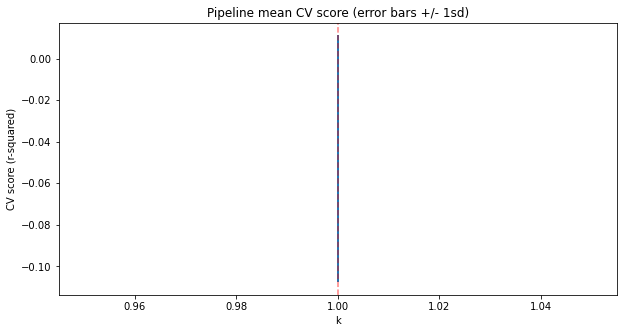

In [37]:
score_mean = lr_grid_cv.cv_results_['mean_test_score']
score_std = lr_grid_cv.cv_results_['std_test_score']
cv_k = [k for k in lr_grid_cv.cv_results_['param_selectkbest__k']]

best_k = lr_grid_cv.best_params_['selectkbest__k']
plt.subplots(figsize=(10, 5))
plt.errorbar(cv_k, score_mean, yerr=score_std)
plt.axvline(x=best_k, c='r', ls='--', alpha=.5)
plt.xlabel('k')
plt.ylabel('CV score (r-squared)')
plt.title('Pipeline mean CV score (error bars +/- 1sd)');

### Benchmark Model 1 Metrics

#### R-squared (COD)

In [38]:
#Cross-validation defaults to R^2 metric for scoring regression
lr_best_cv_results = cross_validate(lr_grid_cv.best_estimator_, X_train, y_train, cv=5)
lr_best_scores = lr_best_cv_results['test_score']
lr_best_scores

C:\Users\jraks\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
C:\Users\jraks\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
C:\Users\jraks\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
C:\Users\jraks\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
C:\Users\jraks\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


array([-7.19259113e-05, -3.31187525e-02, -1.42216162e-04, -4.67502875e-02,
       -1.61420243e-01])

In [39]:
#Training set CV mean and std
np.mean(lr_best_scores), np.std(lr_best_scores)

(-0.048300685097521126, 0.059454487819675814)

#### Mean Absolute Error (MAE)

In [40]:
lr_neg_mae = cross_validate(lr_grid_cv.best_estimator_, X_train, y_train, 
                            scoring='neg_mean_absolute_error', cv=5, n_jobs=-1)

In [41]:
# Training set MAE and STD 
lr_mae_mean = np.mean(-1 * lr_neg_mae['test_score'])
lr_mae_std = np.std(-1 * lr_neg_mae['test_score'])
MAE_LR_train = lr_mae_mean, lr_mae_std
MAE_LR_train

(5.073996116493735, 0.36697127944098734)

In [42]:
# Test set mean
MAE_LR_test = mean_absolute_error(y_test, lr_grid_cv.best_estimator_.predict(X_test))
MAE_LR_test

6.023393341076269

#### Mean Squared Error (MSE)

In [43]:
lr_neg_mse = cross_validate(lr_grid_cv.best_estimator_, X_train, y_train, 
                            scoring='neg_mean_squared_error', cv=5)

C:\Users\jraks\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
C:\Users\jraks\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
C:\Users\jraks\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
C:\Users\jraks\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
C:\Users\jraks\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


In [44]:
#Training set CV mean and std
lr_mse_mean = np.mean(-1 * lr_neg_mse['test_score'])
lr_mse_std = np.std(-1 * lr_neg_mse['test_score'])
MSE_LR_train = lr_mse_mean, lr_mse_std
MSE_LR_train

(43.98744888367915, 10.131458326219693)

In [45]:
# Test set mean
MSE_LR_test = mean_squared_error(y_test, lr_grid_cv.best_estimator_.predict(X_test))
MSE_LR_test

64.65650315881305

#### Root Mean Square Error (RMSE)

In [46]:
lr_neg_rmse = cross_validate(lr_grid_cv.best_estimator_, X_train, y_train, 
                            scoring='neg_root_mean_squared_error', cv=5)

C:\Users\jraks\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
C:\Users\jraks\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
C:\Users\jraks\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
C:\Users\jraks\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
C:\Users\jraks\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


In [47]:
#Training set CV mean and std
lr_rmse_mean = np.mean(-1 * lr_neg_rmse['test_score'])
lr_rmse_std = np.std(-1 * lr_neg_rmse['test_score'])
RMSE_LR_train = lr_rmse_mean, lr_rmse_std
RMSE_LR_train

(6.588791040765275, 0.758473140467339)

In [48]:
# Test set mean
RMSE_LR_test = np.sqrt(mean_squared_error(y_test, lr_grid_cv.best_estimator_.predict(X_test)))
RMSE_LR_test

8.040926759945837

### Best Linear Model Feature Importance

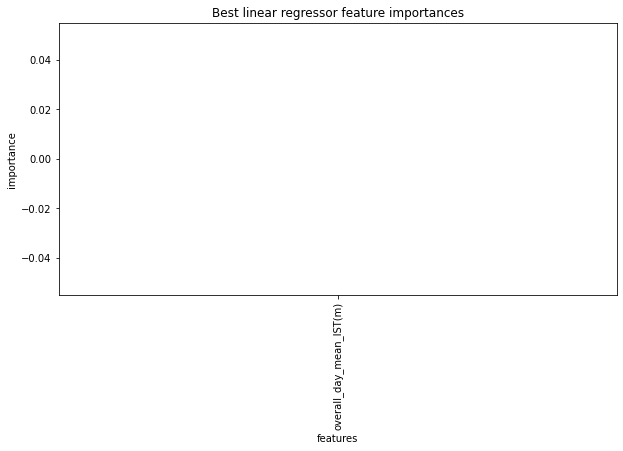

In [49]:
#Plots a barplot of the linear regressor feature importances,
#assigning the `feature_importances_` attribute of 
#`lv_grid_cv.best_estimator_.named_steps.linearregression` to the name `imps` to then
#create a pandas Series object of the feature importances, with the index given by the
#training data column names, sorting the values in descending order
selected = lr_grid_cv.best_estimator_.named_steps.selectkbest.get_support()
plt.subplots(figsize=(10, 5))
imps = lr_grid_cv.best_estimator_.named_steps.linearregression.coef_
lr_feat_imps = pd.Series(imps, index=X_train.columns[selected]).sort_values(ascending=False)
lr_feat_imps.plot(kind='bar')
plt.xlabel('features')
plt.ylabel('importance')
plt.title('Best linear regressor feature importances');

### Save Best Linear Model Object From Pipeline

In [50]:
# save the best linear model
best_model = lr_grid_cv.best_estimator_
best_model.version = '1.0'
best_model.pandas_version = pd.__version__
best_model.numpy_version = np.__version__
best_model.sklearn_version = sklearn_version
best_model.X_columns = [col for col in X_train.columns]
best_model.build_datetime = datetime.datetime.now()

modelpath = '../models'
save_file(best_model, 'IS1_Sun_benchmark_linearmodel.pkl', modelpath)

Writing file.  "../models\IS1_Sun_benchmark_linearmodel.pkl"


### Save Prediction Metrics from Dummy Model and Benchmark Model 1

In [51]:
# save other data for model comparisons in machine learning model stage
comp_data_from3_IST = (MAEs_dummy, MSEs_dummy, RMSEs_dummy, MAE_LR_train, MAE_LR_test, MSE_LR_train, MSE_LR_test, RMSE_LR_train, RMSE_LR_test)
with open('../data/IST_Sun_benchmark.pickle', 'wb') as f:
    pickle.dump(comp_data_from3_IST, f)

### Conclusions 